# Gesture Recognition
In this group project, you are going to build a 3D Conv model, 2D Conv + LSTM that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.

In [1]:
import numpy as np
import os
#from scipy.misc import imread, imresize
from imageio import imread
import datetime
import os
from skimage.transform import resize

We set the random seed so that the results don't vary drastically.

In [2]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
#tf.set_random_seed(30)
# Set random seed for TensorFlow
tf.random.set_seed(30)
import cv2
# Set random seed for Numpy if needed
np.random.seed(30)

#### We mount the google drive where data has been uploaded

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#### First we try with
#### Batch size = 51
#### No of images = 20
#### Input shape = (100*100)

In [4]:
train_doc = np.random.permutation(open('/content/drive/MyDrive/Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('/content/drive/MyDrive/Project_data/val.csv').readlines())
batch_size = 51
#experiment with the batch size

In [5]:
def getImgTensor(n_frames):
    img_idx = np.round(np.linspace(0, 29, n_frames)).astype(int)
    return [img_idx, 100, 100, 3]

# define image tensor size
img_tensor = getImgTensor(20)
print ('# img_tensor =', img_tensor)

# img_tensor = [array([ 0,  2,  3,  5,  6,  8,  9, 11, 12, 14, 15, 17, 18, 20, 21, 23, 24,
       26, 27, 29]), 100, 100, 3]


## Generator

In [6]:
def generator(source_path, folder_list, batch_size, img_tensor, augment=False):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    [x,y,z] = [len(img_tensor[0]),img_tensor[1], img_tensor[2]]
    img_idx = img_tensor[0]
    #np.round(np.linspace(0,self.total_frames-1,self.frames_to_sample)).astype(int)
    #[0,1,2,5,8,9,10,12,15,16,20,22,24,25,26,27,28]
    #create a list of image numbers you want to use for a particular video
    while True:
        t = np.random.permutation(folder_list)
        num_batches = int(len(t))//batch_size # calculate the number of batches
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size,int(len(img_idx)),y,z,3))
            # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx):
                    #performing image reading and resizing
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    image_resized=resize(image,(y,z,3))

                    #normalizing the images
                    batch_data[folder,idx,:,:,0] = (image_resized[:,:,0])/255
                    batch_data[folder,idx,:,:,1] = (image_resized[:,:,1])/255
                    batch_data[folder,idx,:,:,2] = (image_resized[:,:,2])/255

                    if (augment):
                        shifted = cv2.warpAffine(image,
                                                 np.float32([[1, 0, np.random.randint(-30,30)],[0, 1, np.random.randint(-30,30)]]),
                                                (image.shape[1], image.shape[0]))

                        gray = cv2.cvtColor(shifted,cv2.COLOR_BGR2GRAY)

                        x0, y0 = np.argwhere(gray > 0).min(axis=0)
                        x1, y1 = np.argwhere(gray > 0).max(axis=0)
                        # cropping the images to have the targeted gestures and remove the noise from the images.
                        cropped=shifted[x0:x1,y0:y1,:]

                        image_resized=resize(cropped,(self.image_height,self.image_width,3))

                        #shifted = cv2.warpAffine(image_resized,
                        #                        np.float32([[1, 0, np.random.randint(-3,3)],[0, 1, np.random.randint(-3,3)]]),
                        #                        (image_resized.shape[1], image_resized.shape[0]))

                        batch_data_aug[folder,idx,:,:,0] = (image_resized[:,:,0])/255
                        batch_data_aug[folder,idx,:,:,1] = (image_resized[:,:,1])/255
                        batch_data_aug[folder,idx,:,:,2] = (image_resized[:,:,2])/255


                    batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do


        # write the code for the remaining data points which are left after full batches


In [7]:
curr_dt_time = datetime.datetime.now()
train_path = '/content/drive/MyDrive/Project_data/train'
val_path = '/content/drive/MyDrive/Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 10# choose the number of epochs
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 10


In [ ]:
# check complete batch shape
sample_generator = generator(train_path, train_doc, batch_size, img_tensor)
sample_batch_data, sample_batch_labels = next(sample_generator)
print(sample_batch_data.shape)

# validation batch sample
sample_val_generator = generator(val_path, val_doc, batch_size, img_tensor)
sample_val_batch_data, sample_val_batch_labels = next(sample_val_generator)
print(sample_val_batch_data.shape)

Source path =  /content/drive/MyDrive/Project_data/train ; batch size = 51


<ipython-input-6-b1a893ef3691>:19: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)


(51, 20, 100, 100, 3)
Source path =  /content/drive/MyDrive/Project_data/val ; batch size = 51
(51, 20, 100, 100, 3)


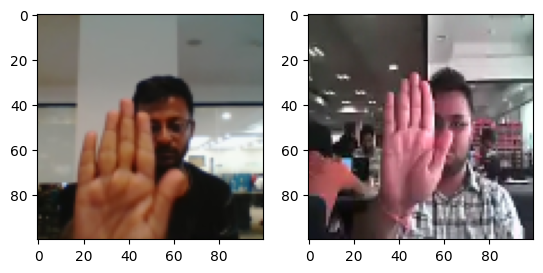

In [ ]:
import matplotlib.pyplot as plt
# plot generated sample images
fig, ax = plt.subplots(1,2)
ax[0].imshow(sample_val_batch_data[16,10,:,:,:])
ax[1].imshow(sample_val_batch_data[30,10,:,:,:])
plt.show()

## Model

##### Define a function to generate plot of accuracy and loss

In [8]:
def plotModelHistory(h):
    fig, ax = plt.subplots(1, 2, figsize=(15,4))
    ax[0].plot(h.history['loss'])
    ax[0].plot(h.history['val_loss'])
    ax[0].legend(['loss','val_loss'])
    ax[0].title.set_text("Train loss vs Validation loss")

    ax[1].plot(h.history['categorical_accuracy'])
    ax[1].plot(h.history['val_categorical_accuracy'])
    ax[1].legend(['categorical_accuracy','val_categorical_accuracy'])
    ax[1].title.set_text("Train accuracy vs Validation accuracy")
    plt.show()

    print("Max. Training Accuracy", max(h.history['categorical_accuracy']))
    print("Max. Validaiton Accuracy", max(h.history['val_categorical_accuracy']))

In [9]:
from keras.models import Sequential, Model
from tensorflow import keras
from keras.layers import Dense, Dropout, GRU, LSTM, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation
from keras.layers import Conv3D, Conv2D, MaxPooling3D, MaxPooling2D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers
num_classes = 5
inputshape=(len(img_tensor[0]),img_tensor[1], img_tensor[2], img_tensor[3])
#write your model here

### Conv3D model

In [10]:
model = Sequential()

model.add(Conv3D(64, (3, 3, 3), strides=(1, 1, 1), padding="same",
                 input_shape=inputshape))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPooling3D(pool_size=(2, 2, 1), strides=(2, 2, 1)))

model.add(Conv3D(128, (3, 3, 3), strides=(1, 1, 1), padding="same"))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPooling3D(pool_size=(2, 2, 1), strides=(2, 2, 1)))

#model.add(Conv3D(256, (3, 3, 3), strides=(1, 1, 1), padding="same"))
#model.add(BatchNormalization())
#model.add(Activation("elu"))
#model.add(MaxPooling3D(pool_size=(2, 2, 1), strides=(2, 2, 1)))

# Flatten the output before adding Dense layers
model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

optimiser = tf.keras.optimizers.legacy.Adam(lr=0.001, decay=1e-06) #momentum=0.7,, nesterov=True
#write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['accuracy'])
print (model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 20, 100, 100, 64   5248      
                             )                                   
                                                                 
 batch_normalization (Batch  (None, 20, 100, 100, 64   256       
 Normalization)              )                                   
                                                                 
 activation (Activation)     (None, 20, 100, 100, 64   0         
                             )                                   
                                                                 
 max_pooling3d (MaxPooling3  (None, 10, 50, 100, 64)   0         
 D)                                                              
                                                                 
 conv3d_1 (Conv3D)           (None, 10, 50, 100, 128   2

/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/legacy/adam.py:118: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


#### Create Train & Validation generator

In [11]:
train_generator = generator(train_path, train_doc, batch_size, img_tensor)
val_generator = generator(val_path, val_doc, batch_size, img_tensor)

#### Write output file for model with checkpoint for learning rate

In [12]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'

if not os.path.exists(model_name):
    os.mkdir(model_name)

filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4)

# callbacks_list = [checkpoint, LR]
callbacks_list = [checkpoint, LR]

The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

In [13]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

### VGG16 Model with LSTM

In [14]:
from keras.applications.vgg16 import VGG16

base_model = VGG16(include_top=False, weights='imagenet', input_shape=(100,100,3))
x=base_model.output
x=Flatten()(x)
#x.add(Dropout(0.5))
features = Dense(64, activation='relu')(x)
conv_model = Model(inputs=base_model.input, outputs=features)

for layers in base_model.layers:
    layers.trainable = False

model2 = Sequential()
model2.add(TimeDistributed(conv_model, input_shape=inputshape))
model2.add(GRU(32, return_sequences=True))
#model2.add(GRU(32))
model2.add(GRU(16))
model2.add(Dropout(0.15))
model2.add(Dense(8, activation='relu'))
model2.add(Dense(5, activation='softmax'))

optimiser = tf.keras.optimizers.legacy.Adam(lr=0.001, decay=1e-06)#momentum=0.7,, nesterov=True
model2.compile(optimizer=optimizers.Adam(), loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model2.summary())

58889256/58889256 [==============================] - 0s 0us/step
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDist  (None, 20, 64)            15009664  
 ributed)                                                        
                                                                 
 gru (GRU)                   (None, 20, 32)            9408      
                                                                 
 gru_1 (GRU)                 (None, 16)                2400      
                                                                 
 dropout (Dropout)           (None, 16)                0         
                                                                 
 dense_3 (Dense)             (None, 8)                 136       
                                                                 
 dense_4 (Dense)             (None, 5)                 

### Conv2D model + RNN max pooling with LSTM

In [15]:
model3 = Sequential()

model3.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),
                                  input_shape=(18,84,84,3)))
model3.add(TimeDistributed(BatchNormalization()))
model3.add(TimeDistributed(MaxPooling2D((2, 2))))

model3.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
model3.add(TimeDistributed(BatchNormalization()))
model3.add(TimeDistributed(MaxPooling2D((2, 2))))

model3.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
model3.add(TimeDistributed(BatchNormalization()))
model3.add(TimeDistributed(MaxPooling2D((2, 2))))

model3.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
model3.add(TimeDistributed(BatchNormalization()))
model3.add(TimeDistributed(MaxPooling2D((2, 2))))

model3.add(TimeDistributed(Conv2D(256, (3, 3) , padding='same', activation='relu')))
model3.add(TimeDistributed(BatchNormalization()))
model3.add(TimeDistributed(MaxPooling2D((2, 2))))

#model.add(TimeDistributed(Conv2D(512, (2, 2) , padding='valid', activation='relu')))
# model.add(TimeDistributed(BatchNormalization()))
# model.add(TimeDistributed(MaxPooling2D((2, 2))))

model3.add(TimeDistributed(Flatten()))
dropout=0.2
model3.add(LSTM(64))
model3.add(Dropout(dropout))

model3.add(Dense(64,activation='relu'))
model3.add(Dropout(dropout))

model3.add(Dense(5, activation='softmax'))

optimiser = tf.keras.optimizers.legacy.Adam(lr=0.001, decay=1e-06)#momentum=0.7,, nesterov=True
model3.compile(optimizer=optimizers.Adam(), loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model3.summary())


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_1 (TimeDi  (None, 18, 84, 84, 16)    448       
 stributed)                                                      
                                                                 
 time_distributed_2 (TimeDi  (None, 18, 84, 84, 16)    64        
 stributed)                                                      
                                                                 
 time_distributed_3 (TimeDi  (None, 18, 42, 42, 16)    0         
 stributed)                                                      
                                                                 
 time_distributed_4 (TimeDi  (None, 18, 42, 42, 32)    4640      
 stributed)                                                      
                                                                 
 time_distributed_5 (TimeDi  (None, 18, 42, 42, 32)   

### MobileNet max pooling with LSTM

In [16]:
def make3dFilter(x):
    return tuple([x]*3)

def make2dFilter(x):
    return tuple([x]*2)

from tensorflow.keras.applications import mobilenet
from tensorflow.keras.layers import TimeDistributed, BatchNormalization, Flatten, LSTM, Lambda

mobilenet = mobilenet.MobileNet(weights='imagenet', include_top=False)
model7 = Sequential([
    TimeDistributed(mobilenet, input_shape=inputshape)
], name="mobilenet_lstm")

for layer in model7.layers:
    layer.trainable = False

model7.add(TimeDistributed(BatchNormalization()))
TimeDistributed(MaxPooling2D(make2dFilter(2)))
model7.add(TimeDistributed(Flatten()))

model7.add(LSTM(256))
model7.add(Dropout(0.2))

model7.add(Dense(256,activation='relu'))
model7.add(Dropout(0.2))

model7.add(Dense(5, activation='softmax'))

optimiser = tf.keras.optimizers.legacy.Adam(lr=0.001, decay=1e-06)#momentum=0.7,, nesterov=True
model7.compile(optimizer=optimizers.Adam(), loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model7.summary())

17225924/17225924 [==============================] - 0s 0us/step
Model: "mobilenet_lstm"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_17 (TimeD  (None, 20, 3, 3, 1024)    3228864   
 istributed)                                                     
                                                                 
 time_distributed_18 (TimeD  (None, 20, 3, 3, 1024)    4096      
 istributed)                                                     
                                                                 
 time_distributed_20 (TimeD  (None, 20, 9216)          0         
 istributed)                                                     
                                                                 
 lstm_1 (LSTM)               (None, 256)               9700352   
                                                                 
 dropout_3 (Dropout)         (None, 256)             

In [ ]:
model7.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=20, verbose=1,
                    callbacks=callbacks_list, validation_data=val_generator,
                    validation_steps=validation_steps, class_weight=None,workers=1, initial_epoch=0)

<ipython-input-7-b1a893ef3691>:19: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)


Epoch 1/20
13/13 [==============================] - ETA: 0s - loss: 1.2548 - categorical_accuracy: 0.5113
Epoch 1: saving model to model_init_2023-12-0114_38_24.665365/model-00001-1.25476-0.51131-1.10853-0.54902.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


13/13 [==============================] - 180s 14s/step - loss: 1.2548 - categorical_accuracy: 0.5113 - val_loss: 1.1085 - val_categorical_accuracy: 0.5490 - lr: 0.0010
Epoch 2/20
13/13 [==============================] - ETA: 0s - loss: 0.5161 - categorical_accuracy: 0.8537
Epoch 2: saving model to model_init_2023-12-0114_38_24.665365/model-00002-0.51611-0.85370-0.92725-0.67647.h5
13/13 [==============================] - 151s 13s/step - loss: 0.5161 - categorical_accuracy: 0.8537 - val_loss: 0.9272 - val_categorical_accuracy: 0.6765 - lr: 0.0010
Epoch 3/20
13/13 [==============================] - ETA: 0s - loss: 0.2017 - categorical_accuracy: 0.9608
Epoch 3: saving model to model_init_2023-12-0114_38_24.665365/model-00003-0.20175-0.96078-0.83623-0.68627.h5
13/13 [==============================] - 156s 13s/step - loss: 0.2017 - categorical_accuracy: 0.9608 - val_loss: 0.8362 - val_categorical_accuracy: 0.6863 - lr: 0.0010
Epoch 4/20
13/13 [==============================] - ETA: 0s - loss

In [ ]:
model3hist=model3.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=20, verbose=1,
                    callbacks=callbacks_list, validation_data=val_generator,
                    validation_steps=validation_steps, class_weight=None,workers=1, initial_epoch=0)

<ipython-input-7-b1a893ef3691>:19: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)


Epoch 1/20
13/13 [==============================] - ETA: 0s - loss: 1.6054 - categorical_accuracy: 0.2383 
Epoch 1: saving model to model_init_2023-12-0114_38_24.665365/model-00001-1.60537-0.23831-1.62196-0.19608.h5
13/13 [==============================] - 171s 14s/step - loss: 1.6054 - categorical_accuracy: 0.2383 - val_loss: 1.6220 - val_categorical_accuracy: 0.1961 - lr: 2.0000e-04
Epoch 2/20


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


13/13 [==============================] - ETA: 0s - loss: 1.5823 - categorical_accuracy: 0.2805
Epoch 2: saving model to model_init_2023-12-0114_38_24.665365/model-00002-1.58232-0.28054-1.62354-0.21569.h5
13/13 [==============================] - 152s 13s/step - loss: 1.5823 - categorical_accuracy: 0.2805 - val_loss: 1.6235 - val_categorical_accuracy: 0.2157 - lr: 2.0000e-04
Epoch 3/20
13/13 [==============================] - ETA: 0s - loss: 1.5847 - categorical_accuracy: 0.2881
Epoch 3: saving model to model_init_2023-12-0114_38_24.665365/model-00003-1.58473-0.28808-1.65133-0.22549.h5
13/13 [==============================] - 149s 12s/step - loss: 1.5847 - categorical_accuracy: 0.2881 - val_loss: 1.6513 - val_categorical_accuracy: 0.2255 - lr: 2.0000e-04
Epoch 4/20
13/13 [==============================] - ETA: 0s - loss: 1.5882 - categorical_accuracy: 0.2670
Epoch 4: saving model to model_init_2023-12-0114_38_24.665365/model-00004-1.58823-0.26697-1.62447-0.16667.h5
13/13 [===============

In [17]:
import matplotlib.pyplot as plt

#### Now plot the model Accuracy and Loss history

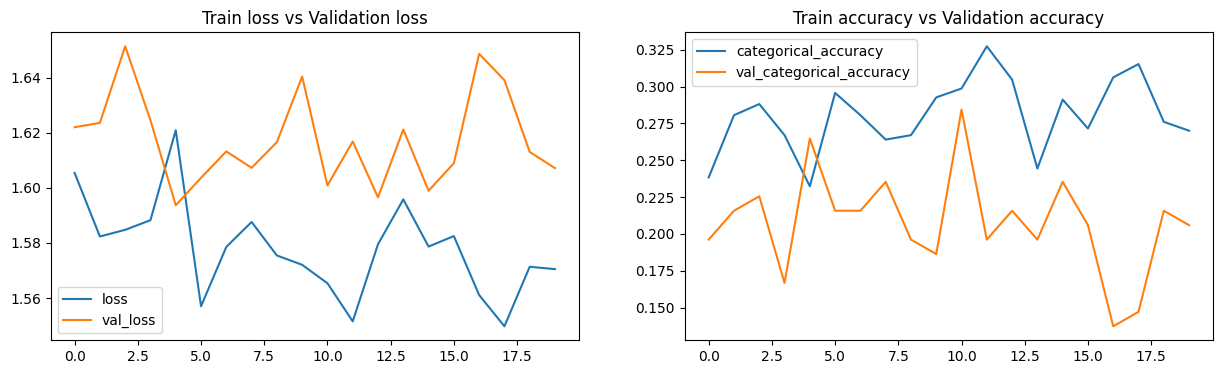

Max. Training Accuracy 0.32730016112327576
Max. Validaiton Accuracy 0.28431373834609985


In [ ]:


plotModelHistory(model3hist)

In [ ]:
model7hist=model7.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=20, verbose=1,
                    callbacks=callbacks_list, validation_data=val_generator,
                    validation_steps=validation_steps, class_weight=None,workers=1, initial_epoch=0)

Source path =  /content/drive/MyDrive/Project_data/train ; batch size = 51


<ipython-input-6-b1a893ef3691>:19: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)


Epoch 1/20
13/13 [==============================] - ETA: 0s - loss: 1.2775 - categorical_accuracy: 0.4600  Source path =  /content/drive/MyDrive/Project_data/val ; batch size = 51

Epoch 1: saving model to model_init_2023-12-0217_58_33.252303/model-00001-1.27752-0.46003-1.18763-0.48039.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


13/13 [==============================] - 3593s 298s/step - loss: 1.2775 - categorical_accuracy: 0.4600 - val_loss: 1.1876 - val_categorical_accuracy: 0.4804 - lr: 0.0010
Epoch 2/20
13/13 [==============================] - ETA: 0s - loss: 0.5081 - categorical_accuracy: 0.8446 
Epoch 2: saving model to model_init_2023-12-0217_58_33.252303/model-00002-0.50814-0.84465-1.14245-0.54902.h5
13/13 [==============================] - 384s 31s/step - loss: 0.5081 - categorical_accuracy: 0.8446 - val_loss: 1.1425 - val_categorical_accuracy: 0.5490 - lr: 0.0010
Epoch 3/20
13/13 [==============================] - ETA: 0s - loss: 0.2130 - categorical_accuracy: 0.9487 
Epoch 3: saving model to model_init_2023-12-0217_58_33.252303/model-00003-0.21298-0.94872-1.08656-0.52941.h5
13/13 [==============================] - 333s 26s/step - loss: 0.2130 - categorical_accuracy: 0.9487 - val_loss: 1.0866 - val_categorical_accuracy: 0.5294 - lr: 0.0010
Epoch 4/20
13/13 [==============================] - ETA: 0s - 

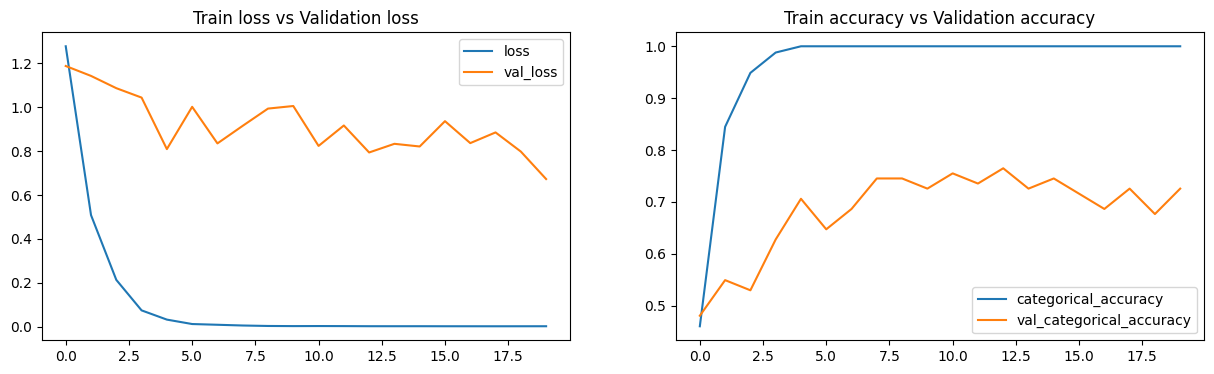

Max. Training Accuracy 1.0
Max. Validaiton Accuracy 0.7647058963775635


In [ ]:
plotModelHistory(model7hist)

### Now we make the batch size =32
### No of trainable images = 24
### Input shape = (84*84)

In [18]:
def getImgTensor2(n_frames):
    img_idx = np.round(np.linspace(0, 29, n_frames)).astype(int)
    return [img_idx, 84, 84, 3]

# define image tensor size
img_tensor2 = getImgTensor2(24)
print ('# img_tensor =', img_tensor2)

batch_size2 = 32
print ('# Batch size =', batch_size2)

# img_tensor = [array([ 0,  1,  3,  4,  5,  6,  8,  9, 10, 11, 13, 14, 15, 16, 18, 19, 20,
       21, 23, 24, 25, 26, 28, 29]), 84, 84, 3]
# Batch size = 32


In [19]:
if (num_train_sequences%batch_size2) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size2)
else:
    steps_per_epoch = (num_train_sequences//batch_size2) + 1

if (num_val_sequences%batch_size2) == 0:
    validation_steps = int(num_val_sequences/batch_size2)
else:
    validation_steps = (num_val_sequences//batch_size2) + 1

In [20]:
def generator2(source_path, folder_list, batch_size, img_tensor, augment=False):
    print( 'Source path = ', source_path, '; batch size =', batch_size2)
    [x,y,z] = [len(img_tensor[0]),img_tensor[1], img_tensor[2]]
    img_idx = img_tensor[0]
    #np.round(np.linspace(0,self.total_frames-1,self.frames_to_sample)).astype(int)
    #[0,1,2,5,8,9,10,12,15,16,20,22,24,25,26,27,28]
    #create a list of image numbers you want to use for a particular video
    while True:
        t = np.random.permutation(folder_list)
        num_batches = int(len(t))//batch_size # calculate the number of batches
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size,int(len(img_idx)),y,z,3))
            # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx):
                    #performing image reading and resizing
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    image_resized=resize(image,(y,z,3))

                    #normalizing the images
                    batch_data[folder,idx,:,:,0] = (image_resized[:,:,0])/255
                    batch_data[folder,idx,:,:,1] = (image_resized[:,:,1])/255
                    batch_data[folder,idx,:,:,2] = (image_resized[:,:,2])/255

                    if (augment):
                        shifted = cv2.warpAffine(image,
                                                 np.float32([[1, 0, np.random.randint(-30,30)],[0, 1, np.random.randint(-30,30)]]),
                                                (image.shape[1], image.shape[0]))

                        gray = cv2.cvtColor(shifted,cv2.COLOR_BGR2GRAY)

                        x0, y0 = np.argwhere(gray > 0).min(axis=0)
                        x1, y1 = np.argwhere(gray > 0).max(axis=0)
                        # cropping the images to have the targeted gestures and remove the noise from the images.
                        cropped=shifted[x0:x1,y0:y1,:]

                        image_resized=resize(cropped,(self.image_height,self.image_width,3))

                        #shifted = cv2.warpAffine(image_resized,
                        #                        np.float32([[1, 0, np.random.randint(-3,3)],[0, 1, np.random.randint(-3,3)]]),
                        #                        (image_resized.shape[1], image_resized.shape[0]))

                        batch_data_aug[folder,idx,:,:,0] = (image_resized[:,:,0])/255
                        batch_data_aug[folder,idx,:,:,1] = (image_resized[:,:,1])/255
                        batch_data_aug[folder,idx,:,:,2] = (image_resized[:,:,2])/255


                    batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

        if int(len(t))%batch_size!=0 :
          batch_size=int(len(t))%batch_size
          for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size,int(len(img_idx)),y,z,3))
            # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx):
                    #performing image reading and resizing
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    image_resized=resize(image,(y,z,3))

                    #normalizing the images
                    batch_data[folder,idx,:,:,0] = (image_resized[:,:,0])/255
                    batch_data[folder,idx,:,:,1] = (image_resized[:,:,1])/255
                    batch_data[folder,idx,:,:,2] = (image_resized[:,:,2])/255

                    if (augment):
                        shifted = cv2.warpAffine(image,
                                                 np.float32([[1, 0, np.random.randint(-30,30)],[0, 1, np.random.randint(-30,30)]]),
                                                (image.shape[1], image.shape[0]))

                        gray = cv2.cvtColor(shifted,cv2.COLOR_BGR2GRAY)

                        x0, y0 = np.argwhere(gray > 0).min(axis=0)
                        x1, y1 = np.argwhere(gray > 0).max(axis=0)
                        # cropping the images to have the targeted gestures and remove the noise from the images.
                        cropped=shifted[x0:x1,y0:y1,:]

                        image_resized=resize(cropped,(self.image_height,self.image_width,3))

                        #shifted = cv2.warpAffine(image_resized,
                        #                        np.float32([[1, 0, np.random.randint(-3,3)],[0, 1, np.random.randint(-3,3)]]),
                        #                        (image_resized.shape[1], image_resized.shape[0]))

                        batch_data_aug[folder,idx,:,:,0] = (image_resized[:,:,0])/255
                        batch_data_aug[folder,idx,:,:,1] = (image_resized[:,:,1])/255
                        batch_data_aug[folder,idx,:,:,2] = (image_resized[:,:,2])/255


                    batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

                   # write the code for the remaining data points which are left after full batches


In [21]:
inputshape2=(len(img_tensor2[0]),img_tensor2[1], img_tensor2[2], img_tensor2[3])

In [22]:
train_generator2 = generator2(train_path, train_doc, batch_size2, img_tensor2)
val_generator2 = generator2(val_path, val_doc, batch_size2, img_tensor2)

In [23]:
model1 = Sequential()

model1.add(Conv3D(32, (3, 3, 3), strides=(1, 1, 1), padding="same",
                 input_shape=(inputshape2)))
model1.add(BatchNormalization())
model1.add(Activation("relu"))
model1.add(MaxPooling3D(pool_size=(2, 2, 1), strides=(2, 2, 1)))

model1.add(Conv3D(64, (3, 3, 3), strides=(1, 1, 1), padding="same"))
model1.add(BatchNormalization())
model1.add(Activation("relu"))
model1.add(MaxPooling3D(pool_size=(2, 2, 1), strides=(2, 2, 1)))

#model1.add(Conv3D(256, (3, 3, 3), strides=(1, 1, 1), padding="same"))
#model1.add(BatchNormalization())
#model1.add(Activation("relu"))
#model1.add(MaxPooling3D(pool_size=(2, 2, 1), strides=(2, 2, 1)))

# Flatten the output before adding Dense layers
model1.add(Flatten())

model1.add(Dense(128, activation='relu'))
model1.add(Dense(num_classes, activation='softmax'))

optimiser = tf.keras.optimizers.legacy.Adam(lr=0.001, decay=1e-06) #momentum=0.7,, nesterov=True
#write your optimizer
model1.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model1.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_2 (Conv3D)           (None, 24, 84, 84, 32)    2624      
                                                                 
 batch_normalization_8 (Bat  (None, 24, 84, 84, 32)    128       
 chNormalization)                                                
                                                                 
 activation_2 (Activation)   (None, 24, 84, 84, 32)    0         
                                                                 
 max_pooling3d_2 (MaxPoolin  (None, 12, 42, 84, 32)    0         
 g3D)                                                            
                                                                 
 conv3d_3 (Conv3D)           (None, 12, 42, 84, 64)    55360     
                                                                 
 batch_normalization_9 (Bat  (None, 12, 42, 84, 64)   

### Conv2D model + RNN max pooling with LSTM

In [24]:
model4 = Sequential()

model4.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),
                                  input_shape=inputshape2))
model4.add(TimeDistributed(BatchNormalization()))
model4.add(TimeDistributed(MaxPooling2D((2, 2))))

model4.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
model4.add(TimeDistributed(BatchNormalization()))
model4.add(TimeDistributed(MaxPooling2D((2, 2))))

model4.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
model4.add(TimeDistributed(BatchNormalization()))
model4.add(TimeDistributed(MaxPooling2D((2, 2))))

model4.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
model4.add(TimeDistributed(BatchNormalization()))
model4.add(TimeDistributed(MaxPooling2D((2, 2))))

model4.add(TimeDistributed(Conv2D(256, (3, 3) , padding='same', activation='relu')))
model4.add(TimeDistributed(BatchNormalization()))
model4.add(TimeDistributed(MaxPooling2D((2, 2))))

model4.add(TimeDistributed(Flatten()))
dropout=0.2
model4.add(LSTM(128))
model4.add(Dropout(dropout))

model4.add(Dense(128,activation='relu'))
model4.add(Dropout(dropout))

model4.add(Dense(5, activation='softmax'))

optimiser = tf.keras.optimizers.legacy.Adam(lr=0.001, decay=1e-06)#momentum=0.7,, nesterov=True
model4.compile(optimizer=optimizers.Adam(), loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model4.summary())


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_21 (TimeD  (None, 24, 84, 84, 16)    448       
 istributed)                                                     
                                                                 
 time_distributed_22 (TimeD  (None, 24, 84, 84, 16)    64        
 istributed)                                                     
                                                                 
 time_distributed_23 (TimeD  (None, 24, 42, 42, 16)    0         
 istributed)                                                     
                                                                 
 time_distributed_24 (TimeD  (None, 24, 42, 42, 32)    4640      
 istributed)                                                     
                                                                 
 time_distributed_25 (TimeD  (None, 24, 42, 42, 32)   

In [ ]:
model4hist=model4.fit_generator(train_generator2, steps_per_epoch=steps_per_epoch, epochs=10, verbose=1,
                    callbacks=callbacks_list, validation_data=val_generator2,
                    validation_steps=validation_steps, class_weight=None,workers=1, initial_epoch=0)

Source path =  /content/drive/MyDrive/Project_data/train ; batch size = 32


<ipython-input-26-4a67afb9288d>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model4hist=model4.fit_generator(train_generator2, steps_per_epoch=steps_per_epoch, epochs=10, verbose=1,
<ipython-input-21-1991a990a924>:19: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)


Epoch 1/10
19/21 [==========================>...] - ETA: 7:14 - loss: 1.4290 - categorical_accuracy: 0.3586 

<ipython-input-21-1991a990a924>:63: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)


21/21 [==============================] - ETA: 0s - loss: 1.4065 - categorical_accuracy: 0.3680  Source path =  /content/drive/MyDrive/Project_data/val ; batch size = 32

Epoch 1: saving model to model_init_2023-12-0701_31_41.745611/model-00001-1.40652-0.36802-1.59563-0.27000.h5
21/21 [==============================] - 4813s 240s/step - loss: 1.4065 - categorical_accuracy: 0.3680 - val_loss: 1.5956 - val_categorical_accuracy: 0.2700 - lr: 0.0010
Epoch 2/10


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


21/21 [==============================] - ETA: 0s - loss: 1.0745 - categorical_accuracy: 0.5652 
Epoch 2: saving model to model_init_2023-12-0701_31_41.745611/model-00002-1.07446-0.56522-1.94378-0.25000.h5
21/21 [==============================] - 270s 13s/step - loss: 1.0745 - categorical_accuracy: 0.5652 - val_loss: 1.9438 - val_categorical_accuracy: 0.2500 - lr: 0.0010
Epoch 3/10
21/21 [==============================] - ETA: 0s - loss: 0.9791 - categorical_accuracy: 0.6211 
Epoch 3: saving model to model_init_2023-12-0701_31_41.745611/model-00003-0.97912-0.62112-2.15120-0.18750.h5
21/21 [==============================] - 372s 18s/step - loss: 0.9791 - categorical_accuracy: 0.6211 - val_loss: 2.1512 - val_categorical_accuracy: 0.1875 - lr: 0.0010
Epoch 4/10
21/21 [==============================] - ETA: 0s - loss: 0.9126 - categorical_accuracy: 0.6348 
Epoch 4: saving model to model_init_2023-12-0701_31_41.745611/model-00004-0.91258-0.63484-2.04017-0.25000.h5
21/21 [====================

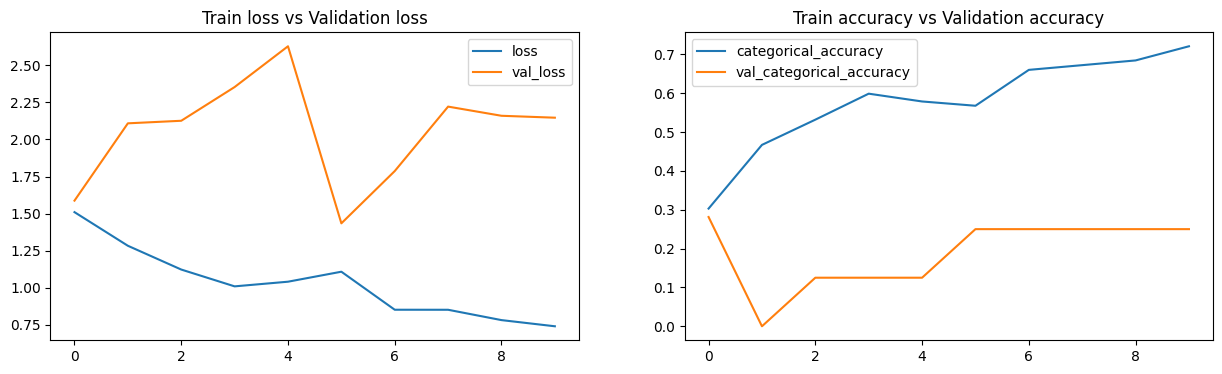

Max. Training Accuracy 0.7206477522850037
Max. Validaiton Accuracy 0.28125


In [ ]:
plotModelHistory(model4hist)

In [34]:
model1hist=model1.fit_generator(train_generator2, steps_per_epoch=steps_per_epoch, epochs=10, verbose=1,
                    callbacks=callbacks_list, validation_data=val_generator2,
                    validation_steps=validation_steps, class_weight=None,workers=1, initial_epoch=0)

<ipython-input-34-b38e95386c71>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model1hist=model1.fit_generator(train_generator2, steps_per_epoch=steps_per_epoch, epochs=10, verbose=1,
<ipython-input-19-1991a990a924>:19: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)


Epoch 1/10
21/21 [==============================] - ETA: 0s - loss: 243.4305 - categorical_accuracy: 0.3081
Epoch 1: saving model to model_init_2023-12-0713_34_06.569531/model-00001-243.43048-0.30812-199.48468-0.18750.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


21/21 [==============================] - 86s 4s/step - loss: 243.4305 - categorical_accuracy: 0.3081 - val_loss: 199.4847 - val_categorical_accuracy: 0.1875 - lr: 0.0010
Epoch 2/10
21/21 [==============================] - ETA: 0s - loss: 40.7025 - categorical_accuracy: 0.3641
Epoch 2: saving model to model_init_2023-12-0713_34_06.569531/model-00002-40.70245-0.36415-136.57434-0.12500.h5
21/21 [==============================] - 84s 4s/step - loss: 40.7025 - categorical_accuracy: 0.3641 - val_loss: 136.5743 - val_categorical_accuracy: 0.1250 - lr: 0.0010
Epoch 3/10
21/21 [==============================] - ETA: 0s - loss: 19.2254 - categorical_accuracy: 0.4706
Epoch 3: saving model to model_init_2023-12-0713_34_06.569531/model-00003-19.22539-0.47059-42.02752-0.12500.h5
21/21 [==============================] - 79s 4s/step - loss: 19.2254 - categorical_accuracy: 0.4706 - val_loss: 42.0275 - val_categorical_accuracy: 0.1250 - lr: 0.0010
Epoch 4/10
21/21 [==============================] - ETA:

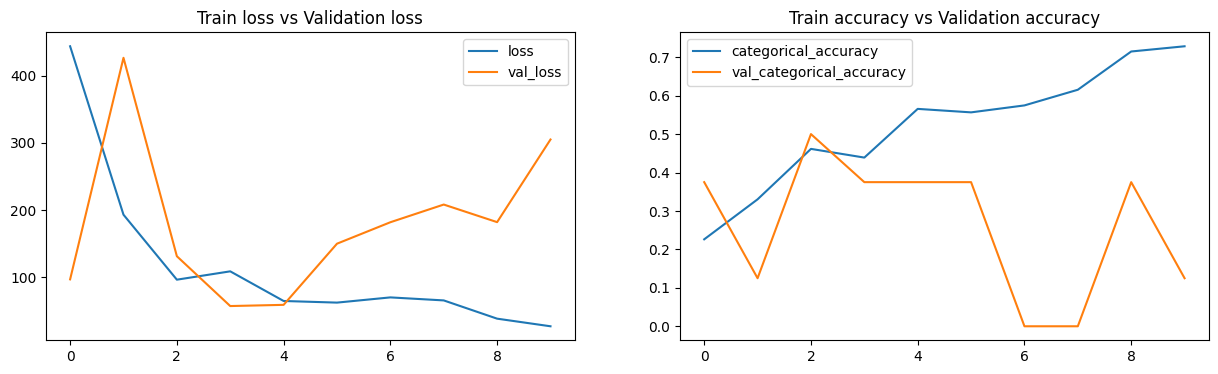

Max. Training Accuracy 0.7285068035125732
Max. Validaiton Accuracy 0.5


In [ ]:
plotModelHistory(model1hist)

### VGG16 Model with LSTM

In [25]:
from keras.applications.vgg16 import VGG16

base_model = VGG16(include_top=False, weights='imagenet', input_shape=(84,84,3))
x=base_model.output
x=Flatten()(x)
#x.add(Dropout(0.5))
features = Dense(64, activation='relu')(x)
conv_model = Model(inputs=base_model.input, outputs=features)

for layers in base_model.layers:
    layers.trainable = False

model21 = Sequential()
model21.add(TimeDistributed(conv_model, input_shape=inputshape2))
model21.add(GRU(32, return_sequences=True))
#model21.add(GRU(32))
model21.add(GRU(16))
model21.add(Dropout(0.15))
model21.add(Dense(8, activation='relu'))
model21.add(Dense(5, activation='softmax'))

optimiser = tf.keras.optimizers.legacy.Adam(lr=0.001, decay=1e-06)#momentum=0.7,, nesterov=True
model21.compile(optimizer=optimizers.Adam(), loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model21.summary())

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_37 (TimeD  (None, 24, 64)            14845824  
 istributed)                                                     
                                                                 
 gru_2 (GRU)                 (None, 24, 32)            9408      
                                                                 
 gru_3 (GRU)                 (None, 16)                2400      
                                                                 
 dropout_7 (Dropout)         (None, 16)                0         
                                                                 
 dense_14 (Dense)            (None, 8)                 136       
                                                                 
 dense_15 (Dense)            (None, 5)                 45        
                                                      

In [ ]:
model21hist=model21.fit_generator(train_generator2, steps_per_epoch=steps_per_epoch, epochs=20, verbose=1,
                    callbacks=callbacks_list, validation_data=val_generator2,
                    validation_steps=validation_steps, class_weight=None,workers=1, initial_epoch=0)

<ipython-input-26-59ba286920af>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model21hist=model21.fit_generator(train_generator2, steps_per_epoch=steps_per_epoch, epochs=20, verbose=1,


Source path =  /content/drive/MyDrive/Project_data/train ; batch size = 32


<ipython-input-20-1991a990a924>:19: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)


Epoch 1/20
19/21 [==========================>...] - ETA: 8:04 - loss: 1.5865 - categorical_accuracy: 0.2681 

<ipython-input-20-1991a990a924>:63: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)


21/21 [==============================] - ETA: 0s - loss: 1.5797 - categorical_accuracy: 0.2821  Source path =  /content/drive/MyDrive/Project_data/val ; batch size = 32

Epoch 1: saving model to model_init_2023-12-0616_34_44.983366/model-00001-1.57971-0.28205-1.46500-0.43000.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


21/21 [==============================] - 5539s 273s/step - loss: 1.5797 - categorical_accuracy: 0.2821 - val_loss: 1.4650 - val_categorical_accuracy: 0.4300 - lr: 0.0010
Epoch 2/20
21/21 [==============================] - ETA: 0s - loss: 1.4386 - categorical_accuracy: 0.3872 
Epoch 2: saving model to model_init_2023-12-0616_34_44.983366/model-00002-1.43863-0.38716-1.43235-0.56250.h5
21/21 [==============================] - 1247s 60s/step - loss: 1.4386 - categorical_accuracy: 0.3872 - val_loss: 1.4323 - val_categorical_accuracy: 0.5625 - lr: 0.0010
Epoch 3/20
21/21 [==============================] - 1233s 59s/step - loss: 1.3122 - categorical_accuracy: 0.4410 - val_loss: 1.3861 - val_categorical_accuracy: 0.3125 - lr: 0.0010
Epoch 4/20
21/21 [==============================] - ETA: 0s - loss: 1.1986 - categorical_accuracy: 0.5012 
Epoch 4: saving model to model_init_2023-12-0616_34_44.983366/model-00004-1.19855-0.50119-1.19478-0.50000.h5
21/21 [==============================] - 1038s 49

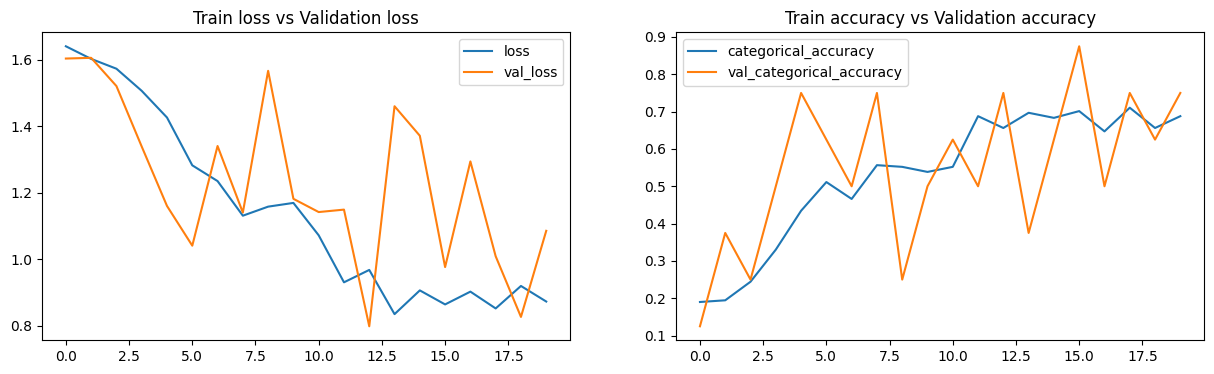

Max. Training Accuracy 0.7104072570800781
Max. Validaiton Accuracy 0.875


In [ ]:
plotModelHistory(model21hist)

### MobileNet max pooling with LSTM

In [26]:
def make3dFilter(x):
    return tuple([x]*3)

def make2dFilter(x):
    return tuple([x]*2)

from tensorflow.keras.applications import mobilenet
from tensorflow.keras.layers import TimeDistributed, BatchNormalization, Flatten, LSTM, Lambda

mobilenet = mobilenet.MobileNet(weights='imagenet', include_top=False)
model71 = Sequential([
    TimeDistributed(mobilenet, input_shape=inputshape2)
], name="mobilenet_lstm")

for layer in model7.layers:
    layer.trainable = False

model71.add(TimeDistributed(BatchNormalization()))
TimeDistributed(MaxPooling2D(make2dFilter(2)))
model71.add(TimeDistributed(Flatten()))

model71.add(LSTM(256))
model71.add(Dropout(0.2))

model71.add(Dense(256,activation='relu'))
model71.add(Dropout(0.2))

model71.add(Dense(5, activation='softmax'))

optimiser = tf.keras.optimizers.legacy.Adam(lr=0.001, decay=1e-06)#momentum=0.7,, nesterov=True
model71.compile(optimizer=optimizers.Adam(), loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model71.summary())

Model: "mobilenet_lstm"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_42 (TimeD  (None, 24, 2, 2, 1024)    3228864   
 istributed)                                                     
                                                                 
 time_distributed_43 (TimeD  (None, 24, 2, 2, 1024)    4096      
 istributed)                                                     
                                                                 
 time_distributed_45 (TimeD  (None, 24, 4096)          0         
 istributed)                                                     
                                                                 
 lstm_4 (LSTM)               (None, 256)               4457472   
                                                                 
 dropout_10 (Dropout)        (None, 256)               0         
                                                    

/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/legacy/adam.py:118: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [27]:
model71hist=model71.fit_generator(train_generator2, steps_per_epoch=steps_per_epoch, epochs=20, verbose=1,
                    callbacks=callbacks_list, validation_data=val_generator2,
                    validation_steps=validation_steps, class_weight=None,workers=1, initial_epoch=0)

<ipython-input-27-033c2697236d>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model71hist=model71.fit_generator(train_generator2, steps_per_epoch=steps_per_epoch, epochs=20, verbose=1,


Source path =  /content/drive/MyDrive/Project_data/train ; batch size = 32


<ipython-input-19-1991a990a924>:19: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)


Epoch 1/20
19/21 [==========================>...] - ETA: 7:05 - loss: 1.1845 - categorical_accuracy: 0.5164 

<ipython-input-19-1991a990a924>:63: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)


21/21 [==============================] - ETA: 0s - loss: 1.1445 - categorical_accuracy: 0.5339  Source path =  /content/drive/MyDrive/Project_data/val ; batch size = 32

Epoch 1: saving model to model_init_2023-12-0713_34_06.569531/model-00001-1.14454-0.53394-1.72921-0.33000.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


21/21 [==============================] - 4739s 235s/step - loss: 1.1445 - categorical_accuracy: 0.5339 - val_loss: 1.7292 - val_categorical_accuracy: 0.3300 - lr: 0.0010
Epoch 2/20
21/21 [==============================] - ETA: 0s - loss: 0.5096 - categorical_accuracy: 0.8033
Epoch 2: saving model to model_init_2023-12-0713_34_06.569531/model-00002-0.50960-0.80331-1.15593-0.62500.h5
21/21 [==============================] - 95s 5s/step - loss: 0.5096 - categorical_accuracy: 0.8033 - val_loss: 1.1559 - val_categorical_accuracy: 0.6250 - lr: 0.0010
Epoch 3/20
21/21 [==============================] - ETA: 0s - loss: 0.4364 - categorical_accuracy: 0.8489 
Epoch 3: saving model to model_init_2023-12-0713_34_06.569531/model-00003-0.43643-0.84886-1.91871-0.37500.h5
21/21 [==============================] - 227s 11s/step - loss: 0.4364 - categorical_accuracy: 0.8489 - val_loss: 1.9187 - val_categorical_accuracy: 0.3750 - lr: 0.0010
Epoch 4/20
21/21 [==============================] - ETA: 0s - los

### Download the model from colab to drive

In [28]:
!cp /content/model_init_2023-12-0713_34_06.569531/model-00020-0.05638-0.98319-0.25387-0.93750.h5 /content/drive/MyDrive/Project_data


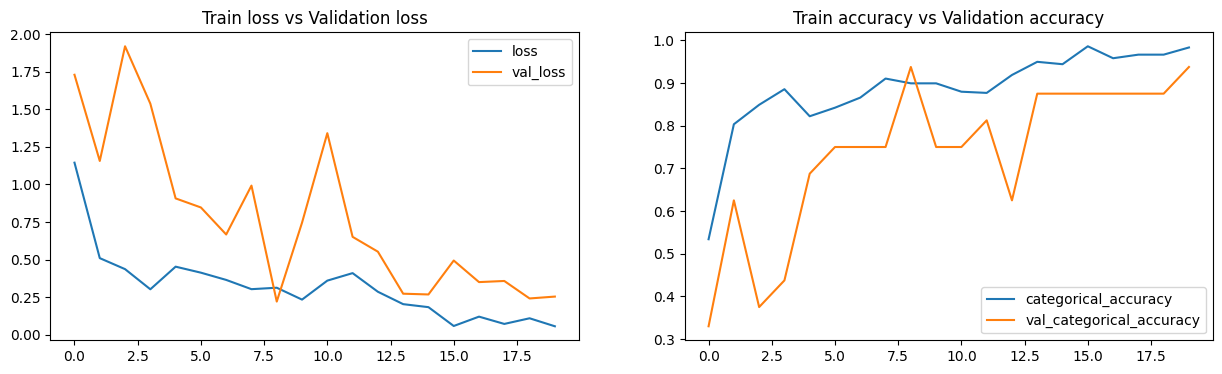

Max. Training Accuracy 0.9859943985939026
Max. Validaiton Accuracy 0.9375


In [31]:
plotModelHistory(model71hist)

In [32]:
!cp /content/model_init_2023-12-0713_34_06.569531/model-00015-0.18354-0.94398-0.26802-0.87500.h5 /content/drive/MyDrive/Project_data

### Conv3D model

In [27]:
model11 = Sequential()

model11.add(Conv3D(32, (3, 3, 3), strides=(1, 1, 1), padding="same",
                 input_shape=(inputshape2)))
model11.add(BatchNormalization())
model11.add(Activation("relu"))
model11.add(MaxPooling3D(pool_size=(2, 2, 1), strides=(2, 2, 1)))

model11.add(Conv3D(64, (3, 3, 3), strides=(1, 1, 1), padding="same"))
model11.add(BatchNormalization())
model11.add(Activation("relu"))
model11.add(MaxPooling3D(pool_size=(2, 2, 1), strides=(2, 2, 1)))

model11.add(Conv3D(256, (3, 3, 3), strides=(1, 1, 1), padding="same"))
model11.add(BatchNormalization())
model11.add(Activation("relu"))
model11.add(MaxPooling3D(pool_size=(2, 2, 1), strides=(2, 2, 1)))

# Flatten the output before adding Dense layers
model11.add(Flatten())

model11.add(Dense(512, activation='relu'))
model11.add(Dense(num_classes, activation='softmax'))

optimiser = tf.keras.optimizers.legacy.Adam(lr=0.001, decay=1e-06) #momentum=0.7,, nesterov=True
#write your optimizer
model11.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model11.summary())

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_7 (Conv3D)           (None, 24, 84, 84, 32)    2624      
                                                                 
 batch_normalization_18 (Ba  (None, 24, 84, 84, 32)    128       
 tchNormalization)                                               
                                                                 
 activation_7 (Activation)   (None, 24, 84, 84, 32)    0         
                                                                 
 max_pooling3d_7 (MaxPoolin  (None, 12, 42, 84, 32)    0         
 g3D)                                                            
                                                                 
 conv3d_8 (Conv3D)           (None, 12, 42, 84, 64)    55360     
                                                                 
 batch_normalization_19 (Ba  (None, 12, 42, 84, 64)   

In [28]:
model11hist=model11.fit_generator(train_generator2, steps_per_epoch=steps_per_epoch, epochs=10, verbose=1,
                    callbacks=callbacks_list, validation_data=val_generator2,
                    validation_steps=validation_steps, class_weight=None,workers=1, initial_epoch=0)

<ipython-input-28-098329d7d7f3>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model11hist=model11.fit_generator(train_generator2, steps_per_epoch=steps_per_epoch, epochs=10, verbose=1,


Source path =  /content/drive/MyDrive/Project_data/train ; batch size = 32


<ipython-input-20-1991a990a924>:19: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)


Epoch 1/10
19/21 [==========================>...] - ETA: 9:56 - loss: 732.9177 - categorical_accuracy: 0.2862 

<ipython-input-20-1991a990a924>:63: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)


21/21 [==============================] - ETA: 0s - loss: 684.4041 - categorical_accuracy: 0.2986  Source path =  /content/drive/MyDrive/Project_data/val ; batch size = 32

Epoch 1: saving model to model_init_2023-12-0815_43_47.044414/model-00001-684.40405-0.29864-791.12000-0.29000.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


21/21 [==============================] - 6662s 332s/step - loss: 684.4041 - categorical_accuracy: 0.2986 - val_loss: 791.1200 - val_categorical_accuracy: 0.2900 - lr: 0.0010
Epoch 2/10
21/21 [==============================] - ETA: 0s - loss: 75.7874 - categorical_accuracy: 0.5590
Epoch 2: saving model to model_init_2023-12-0815_43_47.044414/model-00002-75.78741-0.55901-80.66671-0.25000.h5
21/21 [==============================] - 127s 6s/step - loss: 75.7874 - categorical_accuracy: 0.5590 - val_loss: 80.6667 - val_categorical_accuracy: 0.2500 - lr: 0.0010
Epoch 3/10
21/21 [==============================] - ETA: 0s - loss: 49.1406 - categorical_accuracy: 0.5259 
Epoch 3: saving model to model_init_2023-12-0815_43_47.044414/model-00003-49.14056-0.52588-32.20879-0.50000.h5
21/21 [==============================] - 294s 15s/step - loss: 49.1406 - categorical_accuracy: 0.5259 - val_loss: 32.2088 - val_categorical_accuracy: 0.5000 - lr: 0.0010
Epoch 4/10
21/21 [==============================] 

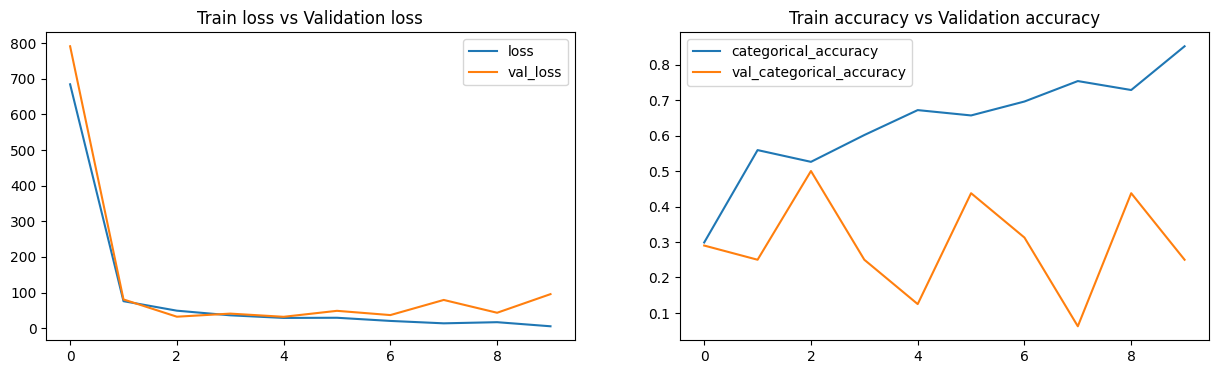

Max. Training Accuracy 0.8515406250953674
Max. Validaiton Accuracy 0.5


In [29]:
plotModelHistory(model11hist)

In [30]:
!cp /content/model_init_2023-12-0815_43_47.044414/model-00003-49.14056-0.52588-32.20879-0.50000.h5 /content/drive/MyDrive/Project_data

#### We can conclude that MobileNet with LSTM gives the best accuracy with below params
#### Now we make the batch size =32
#### No of trainable images = 24
#### Input shape = (84*84)

### Max. Training Accuracy 0.9859943985939026
### Max. Validaiton Accuracy 0.9375